In [194]:
from math import *
from qiskit import *
from qiskit_aer import Aer
import matplotlib.pyplot as plt
from IPython.display import display, Image
from qiskit.visualization import plot_histogram


In [195]:
def quant_fourier_trans(n):
    logic = QuantumRegister(n)
    logic = QuantumCircuit(logic, name="QFT")
    for w in range(n, -1, -1):
        logic.h(n - 1)
        p = 1
        for i in range(w - 1, -1, -1):
            logic.cp(pi / (2**p), i, w)
            p += 1
    s = n - 1
    f = 0
    while f < s:
        logic.swap(f, s)
        f += 1
        s -= 1
    return logic.to_instruction()

In [196]:
def inv_quant_fourier_trans(n):
    logic = QuantumRegister(n)
    logic = QuantumCircuit(logic, name="IQFT")
    s = (n - 1) // 2
    f = n // 2
    while s >= 0:
        if s != f:
            logic.swap(s, f)
        f += 1
        s -= 1
    for w in range(0, n):
        p = w
        for i in range(0, w):
            logic.cp(-pi / (2**p), i, w)
            p -= 1
        logic.h(w)
    return logic.to_instruction()

In [197]:
def fine_tune(n, theta):
    logic = QuantumRegister(n)
    logic = QuantumCircuit(logic, name="fine_tune")
    q = range(n)
    logic.h(q[:-1])
    logic.x(n - 1)
    for i in range(0, n - 1):
        for _ in range(0, 2**i):
            logic.cp(2 * pi * theta, i, n - 1)
    return logic.to_instruction()

In [198]:
# Theta: phase that we want to generate a number in Quant
# N_quibit: number of bits to represent a desired number
def solver(n_quibit, theta):
    q_num = range(n_quibit)
    q = range(n_quibit + 1)
    qc = QuantumCircuit(n_quibit + 1, n_quibit)
    qc.append(fine_tune(n_quibit + 1, theta), q)
    qc.barrier(q)
    qc.append(inv_quant_fourier_trans(n_quibit), q_num)
    qc.barrier(q)
    qc.measure(q_num, q_num)
    return qc
    

In [199]:
def analyse(qc):
    qc = qc.decompose()
    backend_sim = Aer.get_backend("qasm_simulator")
    job_sim = backend_sim.run(qc, shots=2048)
    counts = job_sim.result().get_counts()
    total_counts = sum(counts.values())
    probs = {key: value / total_counts for key, value in counts.items()}
    fig = plot_histogram(probs, title="Quantum")
    fig.savefig("phase_estimation")

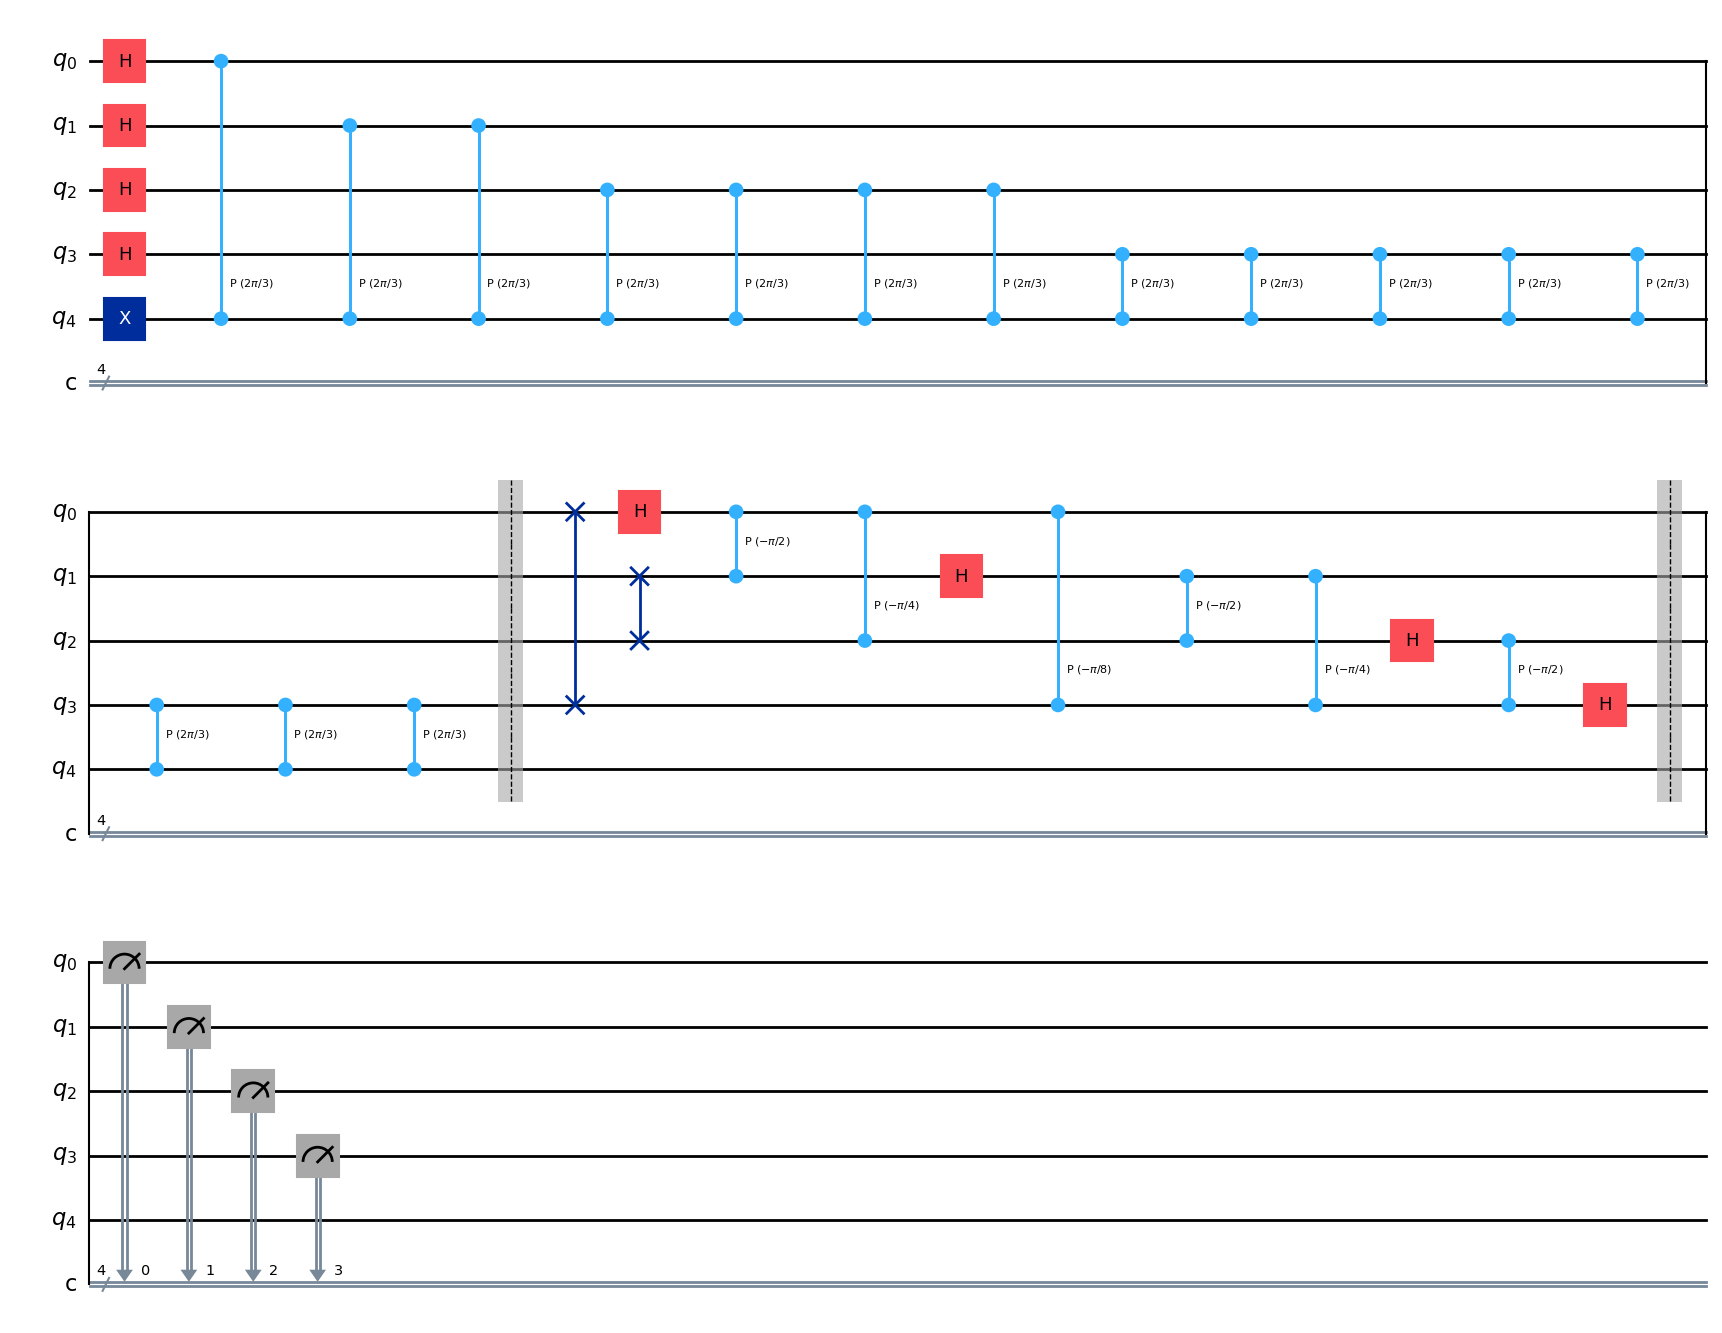

In [205]:
qc = solver(10, 1/3)
analyse(qc)
# qc = qc.decompose()
qc.draw(output="mpl", scale=1)

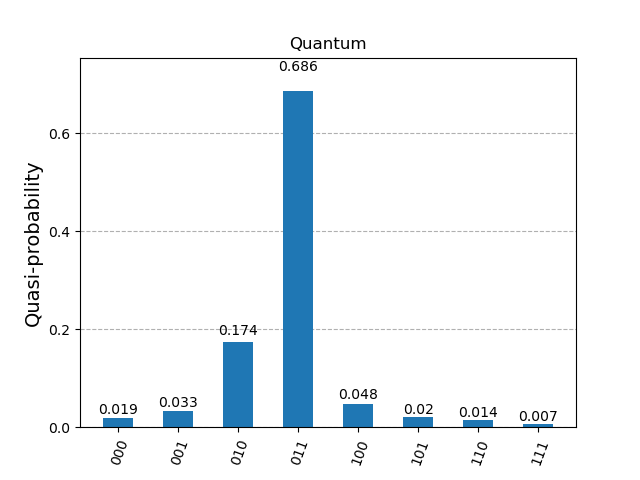

In [201]:
display(Image("phase_estimation.png", width=500))